In [1]:
import cv2
import numpy as np
import imutils
from skimage.filters import threshold_local
import matplotlib.pyplot as plt
import pytesseract
from PIL import Image
import pyttsx3
import keyboard
import pygame
import os

pygame 2.5.2 (SDL 2.28.3, Python 3.11.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


[INFO] Starting video stream from IP Webcam...
Scanned image saved as C:\Users\mehka\Desktop\Smart Office Assistant\input.jpg


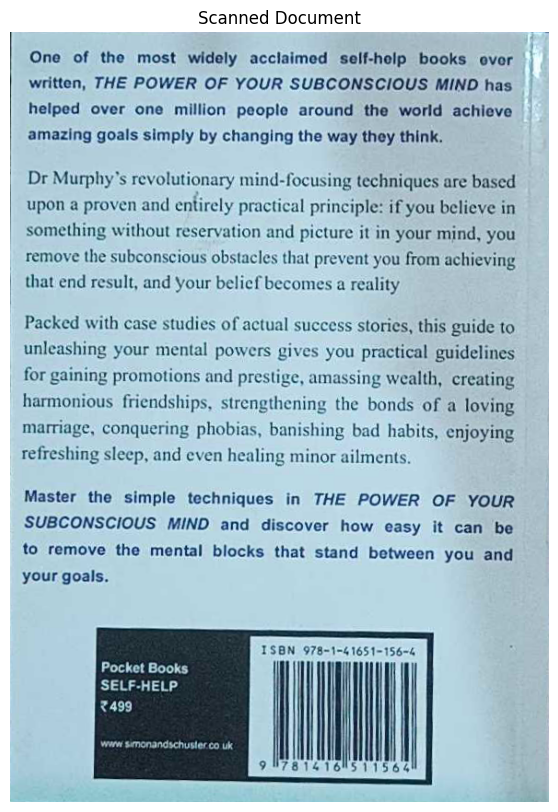

Extracting text from image...

Extracted Text:
One of the most widely acclaimed self-help books over
written, THE POWER OF YOUR SUBCONSCIOUS MIND has
helped over one million people around the world achieve
amazing goals simply by changing the way they think.

Dr Murphy’s revolutionary mind-focusing techniques are based
upon a proven and entirely practical principle: if you believe in
something without reservation and picture it in your mind, you
remove the subconscious obstacles that prevent you from achieving
that end result, and your belief becomes a reality

Packed with case studies of actual success stories, this guide to
unleashing your mental powers gives you practical guidelines
for gaining promotions and prestige, amassing wealth, creating
harmonious friendships, strengthening the bonds of a loving
marriage, conquering phobias, banishing bad habits, enjoying
refreshing sleep, and even healing minor ailments.

Master the simple techniques in THE POWER OF YOUR
SUBCONSCIOUS MIND a

In [ ]:
# Configure Tesseract executable path
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# ---------- Helper Functions for Document Scanner ----------
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]  # Top-left
    rect[2] = pts[np.argmax(s)]  # Bottom-right
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]  # Top-right
    rect[3] = pts[np.argmax(diff)]  # Bottom-left
    return rect

def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    maxWidth = max(int(widthA), int(widthB))

   
    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)    
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth, 0],
        [maxWidth, maxHeight],
        [0, maxHeight]], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped

# ---------- Functions for OCR and Text-to-Speech ----------
def extract_text_from_image(image_path):
    try:
        image = Image.open(image_path)
        extracted_text = pytesseract.image_to_string(image)
        return extracted_text.strip()
    except Exception as e:
        print(f"Error while extracting text: {e}")
        return None

def text_to_speech(text, audio_file="output_audio.wav"):
    try:
        engine = pyttsx3.init()
        engine.setProperty('rate', 150)
        audio_file = os.path.join(os.getcwd(), audio_file)
        engine.save_to_file(text, audio_file)
        engine.runAndWait()
        print(f"Audio saved as {audio_file}")
        return audio_file
    except Exception as e:
        print(f"Error in text-to-speech conversion: {e}")
        return None

def audio_player(audio_file):
    try:
        print("Press 'Enter' to play, 'Space' to pause/resume, and 'Esc' to exit.")
        pygame.mixer.init()
        pygame.mixer.music.load(audio_file)
        paused = False

        while True:
            if keyboard.is_pressed('enter'):
                if not paused:
                    print("Playing audio...")
                    pygame.mixer.music.play()
                    paused = False

            if keyboard.is_pressed('space'):
                if not paused:
                    print("Pausing audio...")
                    pygame.mixer.music.pause()
                    paused = True
                else:
                    print("Resuming audio...")
                    pygame.mixer.music.unpause()
                    paused = False

            if keyboard.is_pressed('esc'):
                print("Exiting audio player.")
                pygame.mixer.music.stop()
                break

    except Exception as e:
        print(f"Error in audio player: {e}")

def image_to_speech(image_path):
    print("Extracting text from image...")
    text = extract_text_from_image(image_path)
    if text:
        print("\nExtracted Text:")
        print(text)
        print("\nConverting text to speech...")
        audio_file = text_to_speech(text)
        if audio_file and os.path.exists(audio_file):
            audio_player(audio_file)
        else:
            print("Audio file could not be generated.")
    else:
        print("No text extracted.")

# ---------- Main Live Scanner Logic ----------
def scan_from_ip_webcam(url):
    print("[INFO] Starting video stream from IP Webcam...")
    
    while True:
        cap = cv2.VideoCapture(url)
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame.")
            break
        
        orig = frame.copy()
        image = imutils.resize(orig, height=500)
        ratio = orig.shape[0] / 500.0

        # Preprocessing
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (7, 7), 0)
        edged = cv2.Canny(blurred, 50, 200)

        # Find contours
        cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:5]
        screenCnt = None

        for c in cnts:
            peri = cv2.arcLength(c, True)
            approx = cv2.approxPolyDP(c, 0.02 * peri, True)
            if len(approx) == 4:
                screenCnt = approx
                break

        # Draw contours if found
        if screenCnt is not None:
            cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
            cv2.putText(image, "Press 's' to scan", (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

        cv2.imshow("Live Document Scanner", image)

        key = cv2.waitKey(1) & 0xFF

        if key == ord('s') and screenCnt is not None:
            # SCAN and Save image
            warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)
            save_path = r"C:\Users\mehka\Desktop\Smart Office Assistant\input.jpg"
            cv2.imwrite(save_path, warped)
            print(f"Scanned image saved as {save_path}")


            # Optional: Show scanned result
            warped_rgb = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(10, 10))
            plt.imshow(warped_rgb)
            plt.title("Scanned Document")
            plt.axis('off')
            plt.show()

            # Now run OCR and Text-to-Speech
            image_to_speech(save_path)

        elif key == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# ---------- Run Everything ----------
if __name__ == "__main__":
    ip_webcam_url = "http://10.11.154.2 1:8080/video"  # Your IP Webcam URL
    scan_from_ip_webcam(ip_webcam_url)
